# Required Imports

In [2]:
import csv
from datetime import datetime, timedelta
from time import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
pd.options.display.min_rows = 25

# Import from Database and frameset_n_questions

In [3]:
df = pd.read_excel("PI_Attempts_RAW.xlsx")#, parse_dates=['created_at'])
df = df.sort_values(by=["user_id", "created_at"])

In [4]:
df['created_at'] = pd.to_datetime(df['created_at'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
test_students = pd.read_csv("Test_Students.csv",header=None)[0].values.tolist()
 

In [6]:
df = df.dropna(subset=['user_id']) # Drop Nan user_id
df = df[~df['user_id'].isin([11604, 5018,3063, 54, 58, 8387, 56, 53, 413, 12740, 1096,  2954, 20182,20232, 20166, 19740, 18381, 1270, 6748, 1270, 8387, 90, 16892])]  # Drop ID's we don't want
df = df[~df['user_id'].isin(test_students)] 

In [7]:
df = df[~df['frame_name'].isin(['NFAtoDFAFF','NFAequivFS'])] 


In [ ]:
frameset_names = pd.read_csv("Frameset_Questions_Coarse_Grained.csv")
old_names = frameset_names['frame_name'].tolist()
new_names = frameset_names["frame_name_22"].tolist()
name_mapper = dict(zip(old_names, new_names))
df['frame_name'] = df['frame_name'].map(name_mapper)

In [10]:
spring_21_end = datetime(2021,5,14)
df = df[df['created_at'] <= spring_21_end]

In [11]:
Fall20 = df[df['created_at'].dt.year==2020]

len(Fall20), len(Fall20['user_id'].unique()), len(Fall20['frame_name'].unique())

(70767, 75, 91)

In [12]:
Spring21 = df[df['created_at'].dt.year==2021]
len(Spring21),  len(Spring21['user_id'].unique()),  len(Spring21['frame_name'].unique())

(126216, 70, 87)

# Some Graphs

In [ ]:
def get_student_info(student_id, database):
    df_student = database[database["user_id"] == student_id].drop(columns="user_id", axis=1)
    framesets = set()
    for index, interaction in df_student.iterrows():
        framesets.add(interaction["frame_name"])
    n_interactions = len(df_student)
    n_framesets = len(framesets)
    return n_interactions, n_framesets

In [ ]:
time_all = time()
n_interactions_per_student = []
n_frames_per_student = []
dictt ={}


for student_id in Spring21_mid1['user_id'].unique():
    student_info = get_student_info(student_id, Spring21_mid1)
    
    n_interactions_per_student.append(student_info[0])
    n_frames_per_student.append(student_info[1])
    dictt[student_id] =student_info[0]

        
print("Total Time (in minutes) is {}".format(timedelta(seconds=(time() - time_all))))

Total Time (in minutes) is 0:00:02.277957


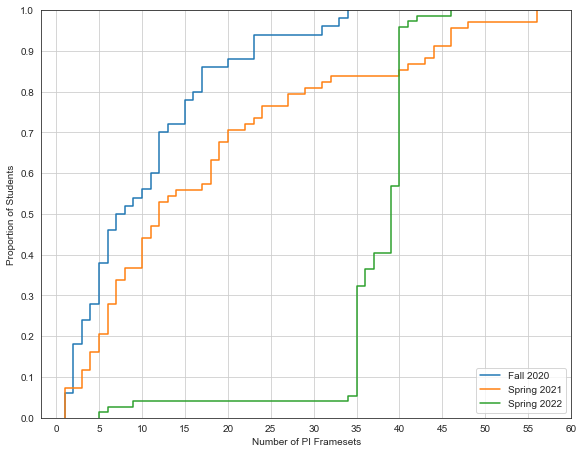

In [180]:
sns.set_style("white")


fig, ax = plt.subplots(figsize=(9.5, 7.5))

gfg = sns.ecdfplot(x = n_frames_per_student20,label="Fall 2020")
gfg = sns.ecdfplot(x = n_frames_per_student21,label="Spring 2021")
gfg = sns.ecdfplot(x = n_frames_per_student22,label="Spring 2022")

gfg.set(
    xlabel="Number of PI Framesets",
    ylabel="Proportion of Students",
    # title="CDF of Framesets Attempted per Student in Fall 2020 (First 5 Weeks)",
    yticks=(np.arange(0,1.1,0.1)),
    xticks=(range(0, max(n_frames_per_student) +5, 5)),
)
plt.legend(loc='lower right')
plt.grid()  
fig.savefig("cdf_framesets_all", facecolor="white",dpi=500)



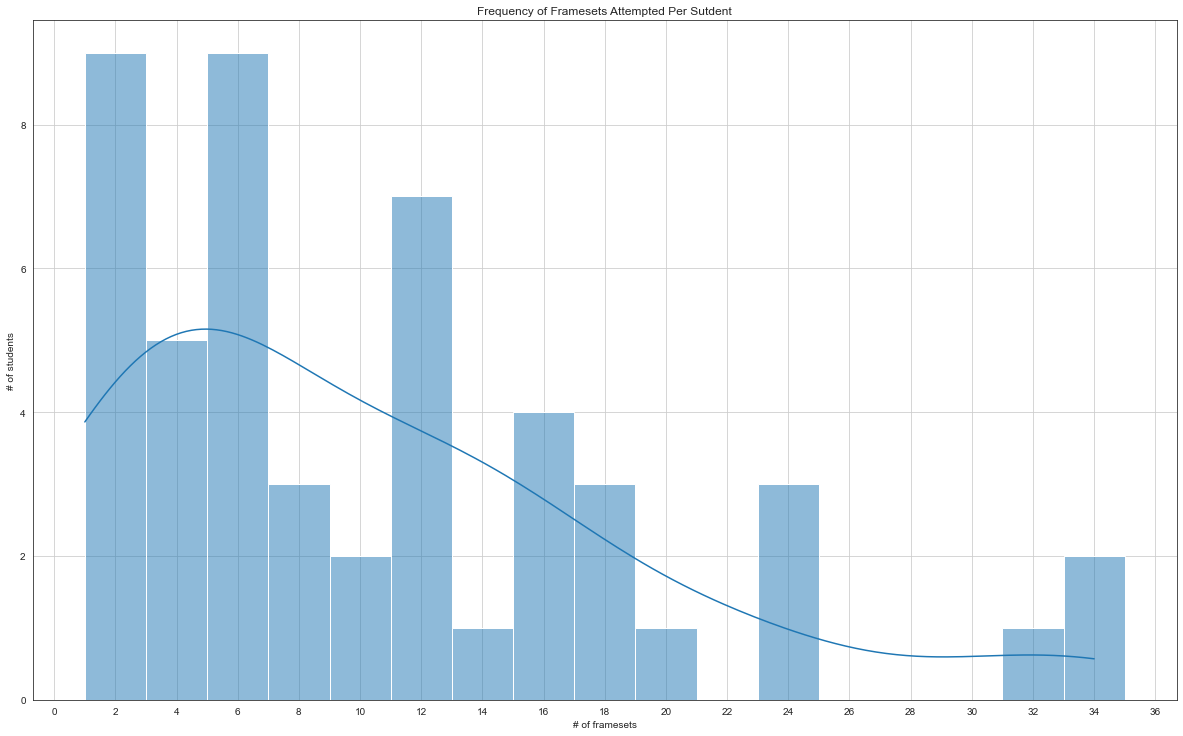

10.32

In [133]:
fig, ax = plt.subplots(figsize=(20.5, 12.5))

gfg = sns.histplot(data=n_frames_per_student, kde=True, binwidth=2)
gfg.set(
    xlabel="# of framesets",
    ylabel="# of students",
    title="Frequency of Framesets Attempted Per Sutdent",
    xticks=(range(0, max(n_frames_per_student) + 3, 2)),
)
plt.grid()  

plt.show()
fig.savefig("Frequency of Framesets Attempted Per Sutdent", facecolor="white")
np.array(n_frames_per_student).mean()

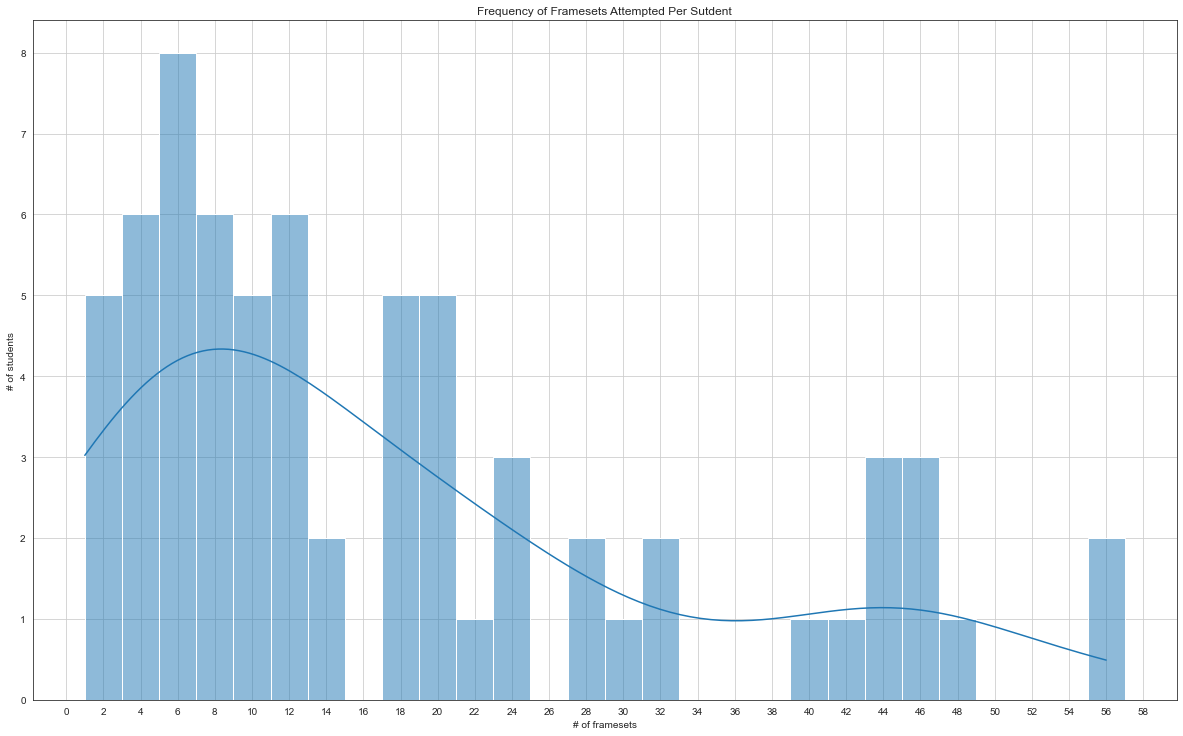

17.602941176470587

In [108]:
fig, ax = plt.subplots(figsize=(20.5, 12.5))

gfg = sns.histplot(data=n_frames_per_student, kde=True, binwidth=2)
gfg.set(
    xlabel="# of framesets",
    ylabel="# of students",
    title="Frequency of Framesets Attempted Per Sutdent",
    xticks=(range(0, max(n_frames_per_student) + 3, 2)),
)
plt.grid()  

plt.show()
fig.savefig("Frequency of Framesets Attempted Per Sutdent", facecolor="white")
np.array(n_frames_per_student).mean()

# Converting Raw Data into Events

## Build CSV one event in a row

In [8]:
session_counter = 1
session_number = "sesssion 1" 
event_log = [] # GLOBAL variable
activity_counter = 0  

def convert_raw_to_sessions_and_activity(student_id, database):
    global session_counter
    global session_number
    df_student = database[database["user_id"] == student_id]
    
    curr  =  df_student.iloc[0]
    prev  =  df_student.iloc[0]
    nextt =  df_student.iloc[0]
    
    # Iterate over interactions of this student
    for i in range(0, len(df_student)):
        
        curr = df_student.iloc[i]
        curr_time = curr["created_at"]
        curr_frameset_name = curr["frame_name"]
        curr_question_id = curr["question"]
        
        
        if i != ( len(df_student) - 1) : #Otherwise, we don't have a next, and it will remain the same
            nextt = df_student.iloc[i + 1]
        
        if i != 0:  #Otherwise, we don't have a prev, and it will remain the same
            prev = df_student.iloc[i - 1]

        if (
            curr_frameset_name == prev["frame_name"]
            and curr_question_id < prev["question"]
        ):
            event_log.append([student_id, session_number, curr_frameset_name, "Back", curr_question_id, curr_time - timedelta(seconds=0.1)])

        # Correct
        if curr["correct"]:
            event_log.append([student_id, session_number, curr_frameset_name, "Crrct", curr_question_id, curr_time ])
 
        # InCorrect
        elif not curr["correct"]:
            event_log.append([student_id, session_number, curr_frameset_name, "X", curr_question_id, curr_time ])

        if (
            nextt["frame_name"] != curr_frameset_name  
            or  ((nextt["created_at"] - curr_time ).total_seconds()/60)>15.0 # Spend some time off - NEW SESSION
            or i == len(df_student) - 1 # means the last session, so his/her last session in that semester
        ):
            
            event_log.append([student_id, session_number, curr_frameset_name, "SESSION_END", curr_question_id,  curr_time + timedelta(seconds=0.001) ])
            session_counter += 1 # A new session, because a new user
            session_number = "sesssion " + str(session_counter)

In [9]:
 
student_ids = df['user_id'].unique()
for student_id in student_ids:
    convert_raw_to_sessions_and_activity(student_id, df)
    
print(len(event_log)) 

207490


In [10]:
sessions =  pd.DataFrame(event_log, columns= ["user_id","session_number","curr_frameset_name","activity_name","question_id","timestamp",])
sessions.to_excel("Sessions_1D_old_names.xlsx")

In [112]:
sessions_intereactions_count20_21 = (
    sessions
    .groupby(["session_number"])
    .agg(
        frameset_count=("curr_frameset_name",  "count"),
    )
) 

In [36]:
%store -r sessions_intereactions_count22

In [ ]:
sessions_interactions_all = sessions_intereactions_count22+ sessions_intereactions_count20_21

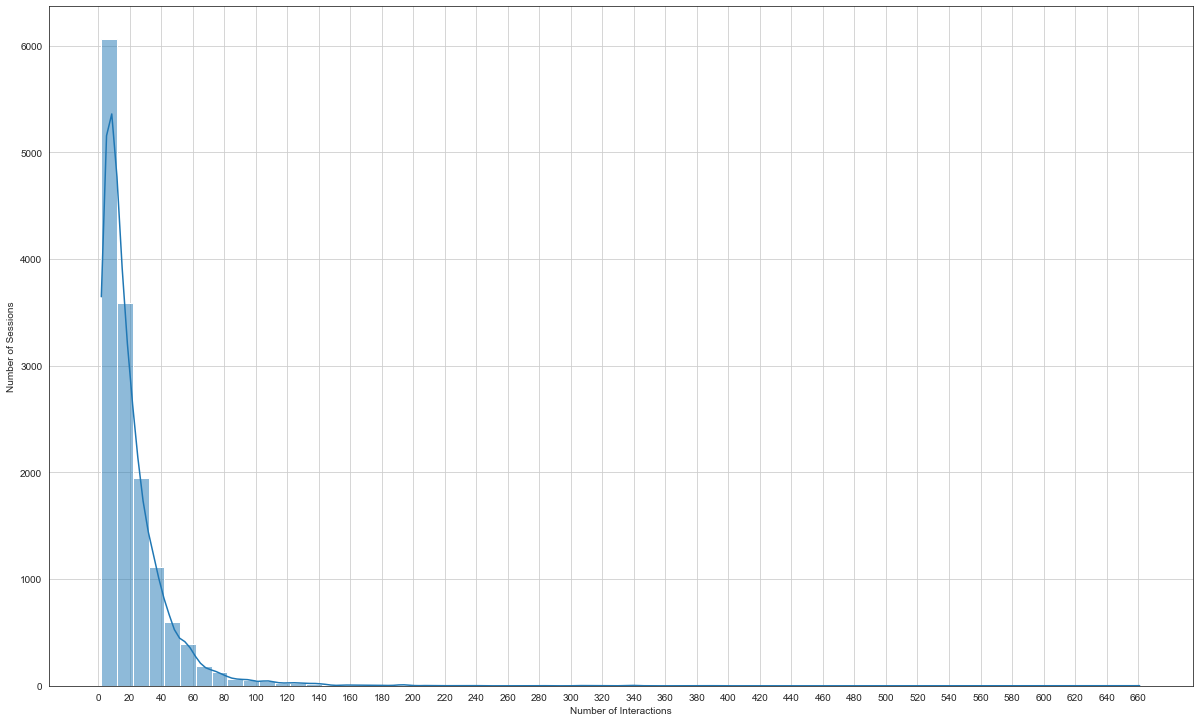

In [121]:
fig, ax = plt.subplots(figsize=(20.5, 12.5))

gfg = sns.histplot(data=sessions_interactions_all, kde=True, binwidth=10)
gfg.set(
    xlabel="Number of Interactions",
    ylabel="Number of Sessions",
    xticks=(range(0, max(sessions_interactions_all), 20)),
)
plt.grid()  

plt.show()

fig.savefig("Number of Interactions Per Session", facecolor="white",dpi=500)


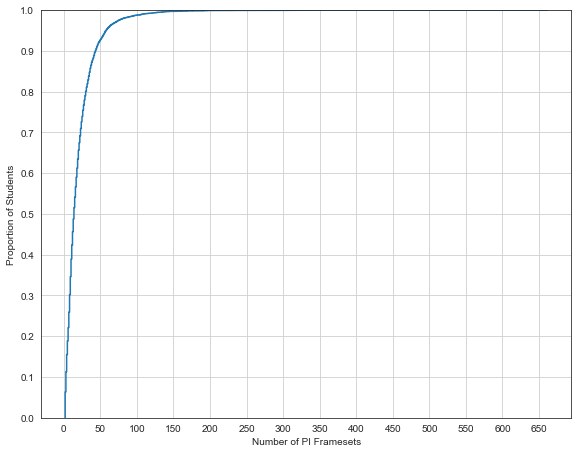

In [93]:
sns.set_style("white")


fig, ax = plt.subplots(figsize=(9.5, 7.5))

gfg = sns.ecdfplot(x = sessions_interactions_all)

gfg.set(
    xlabel="Number of PI Framesets",
    ylabel="Proportion of Students",

    yticks=(np.arange(0,1.1,0.1)),
    xticks=(range(0, max(sessions_interactions_all) +5, 50)),
)
plt.grid()  
fig.savefig("Number of Interactions Per Session", facecolor="white",dpi=500)



In [58]:
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# le.fit(["Crrct", "X", "Back", "SESSION_END"])
# le.classes_
# le.__dict__

{'classes_': array(['Back', 'Crrct', 'SESSION_END', 'X'], dtype='<U11')}

In [ ]:

# event_log has ["user_id", "session_number", "frame_name", "activity_name", "question_id", "timestamp"]
# From the event_log which has only one event per row, we are converting it into a new form (# of datapoints, # of timesteps, # of features)

sessions_one_session_one_row = []
sessions_one_session_one_row_numerical = []
temp = event_log[0][1]
one_row = []
for event in event_log:
    if event[1] != temp:
        sessions_one_session_one_row.append(one_row)

        sessions_one_session_one_row_numerical.append(le.transform(one_row))
        one_row = []
    one_row.append(event[3])
    temp = event[1]

# convert the ragged lists into numpy
sessions_one_session_one_row_numerical = np.asarray(sessions_one_session_one_row_numerical)

In [ ]:
# Transpose the list of lists
sessions_transposed = list(
    map(list, zip_longest(*sessions_one_session_one_row, fillvalue=None))
)

# write list of lists to CSV
with open("sessions_2D.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for values in zip_longest(*sessions_transposed):
        writer.writerow(values)

In [ ]:
sessions_one_session_one_row_numerical

In [ ]:
lengths = [len(x) for x in sessions_one_session_one_row_numerical]

In [ ]:
fig, ax = plt.subplots()
plt.style.use("default")
sns.ecdfplot(data=lengths, legend=True, label="Real Data", color="orange")
plt.xscale("log")
ax.set_title("How many interactions in each session")
ax.set_xlabel("# of interactions per session")
plt.grid()
plt.show()
fig.savefig("How many interactions per session", dpi=300, facecolor="white")

In [ ]:
np.array(lengths).max()

# Creating Attributes for Summarizing Sessions into one datapoint --> (Clustered_Sessions.csv)

In [3]:
clusters_attributes = [
    "Percentage_incorrects",
    "Percentage_corrects",
    "percent_consecutive_incorrect_interactions",  
    'percent_consecutive_correct_interactions',
    "n_backs",
    "nth_trial_of_frame", 
    "time_between_median" ,
]  

In [4]:
clusters_attributes

['Percentage_incorrects',
 'Percentage_corrects',
 'percent_consecutive_incorrect_interactions',
 'percent_consecutive_correct_interactions',
 'n_backs',
 'nth_trial_of_frame',
 'time_between_median']

In [5]:
def get_n_two_conseuctive_incorrect(activities):
    cnt = 0
    flag = False
    for activity in activities:
        if activity == "X" and flag == False:
            flag = True
        elif activity == "X" and flag == True:
            cnt += 1
        elif activity != "X":
            flag = False
    return cnt

def get_n_two_conseuctive_correct(activities):
    cnt = 0
    flag = False
    for activity in activities:
        if activity == "Crrct" and flag == False:
            flag = True
        elif activity == "Crrct" and flag == True:
            cnt += 1
        elif activity != "Crrct":
            flag = False
    return cnt

def get_n_incorrect(activities):
    cnt = 0
    for activity in activities:
        if activity == "X" :
            cnt+=1
    return cnt


def get_n_correct(activities):
    cnt = 0
    for activity in activities:
        if activity == "Crrct" :
            cnt+=1
    return cnt

In [8]:
sessions = pd.read_excel('Sessions_1D_22.xlsx')
sessions.columns

Index(['Unnamed: 0', 'user_id', 'session_number', 'curr_frameset_name',
       'activity_name', 'question_id', 'timestamp'],
      dtype='object')

In [9]:
one_row = []
sessions_attributes = []
sessions_attributes_with_user_frameset = []
attempted_before = {}
n_backs, activity_counter, n_incorrects, n_corrects= 0, 0 , 0 ,0
times_between = []
session_activities = []
question_ids = set()

for interaction in sessions.iterrows():
    interaction = interaction[1]
    activity = interaction['activity_name']
    question_id = interaction['question_id']
    if activity == 'SESSION_END' and activity_counter > 2:
      
        n_consecutive_incorrects = get_n_two_conseuctive_incorrect(session_activities)
        n_consecutive_corrects =   get_n_two_conseuctive_correct(session_activities)
        n_incorrects = get_n_incorrect(session_activities)
        n_corrects = get_n_correct(session_activities)
        percent_consecutive_incorrect_interactions = n_consecutive_incorrects/len(session_activities)
        percent_consecutive_correct_interactions  = n_consecutive_corrects/len(session_activities)
        
        
        if attempted_before.get(str(interaction['user_id']) + "-" + interaction['curr_frameset_name']) == None:
            attempted_before[str(interaction['user_id']) + "-" + interaction['curr_frameset_name']] = 1
        else:  # If the dictionary is not None, it means it have been finished before, and let's count how many times did they finish
            attempted_before[str(interaction['user_id']) + "-" + interaction['curr_frameset_name']]  += 1

        nth_trial_of_frame = attempted_before[str(interaction['user_id']) + "-" + interaction['curr_frameset_name']]
        
 
        one_row = [n_incorrects/len(session_activities), n_corrects/len(session_activities), round(percent_consecutive_incorrect_interactions,3), round(percent_consecutive_correct_interactions,3), 
                  n_backs , nth_trial_of_frame, np.median(times_between)]
        sessions_attributes.append( one_row ) 
        sessions_attributes_with_user_frameset.append([interaction['user_id'], interaction['session_number'], interaction['curr_frameset_name']]+ one_row)  # Adding more info to the row
     
    if activity == 'SESSION_END': # Regardless of the activity_counter
        n_backs = 0
        activity_counter = 0
        start_time = interaction['timestamp']
        times_between = []
        max_question_id = -1
        session_activities = []
        question_ids = set()
        continue # Move directly to the next iteration
    
    
    # add one more activity to that session   
    session_activities.append(activity)
    activity_counter += 1
    
    question_ids.add(question_id)
    
    # If Back
    if activity == "Back":
        n_backs += 1
    
    if activity_counter!=1:
        times_between.append((interaction['timestamp'] - prev_session_time).total_seconds())
    prev_session_time = interaction['timestamp']

In [10]:
sessions_attributes_with_user_frameset = pd.DataFrame(sessions_attributes_with_user_frameset, columns = ['user_id', 'session_number' , 'curr_frameset_name'] + clusters_attributes)

# The Clustering Algorithm

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

import skfuzzy as fuzz
from fcmeans import FCM


In [13]:
traces_attributes = np.asarray(sessions_attributes)
traces_attributes_standardized = StandardScaler().fit_transform(traces_attributes)
traces_attributes_centered = StandardScaler(with_std=False).fit_transform(traces_attributes)
traces_attributes_minmax = MinMaxScaler().fit_transform(traces_attributes)

In [15]:
pca_model = PCA(n_components=2).fit(traces_attributes_standardized)
X_pca = pca_model.transform(traces_attributes_standardized)
pca_model.explained_variance_ratio_ , sum(pca_model.explained_variance_ratio_) #69.6

(array([0.54028121, 0.16905347]), 0.7093346760475615)

## Fuzzy C-Means

In [17]:
cntr = np.load('../centers.npy')

In [18]:
u, u0, d, jm, p, fpc= fuzz.cmeans_predict(X_pca.T, cntr, 2, error=0.005, maxiter=1000, init=None)

In [19]:
fpc

0.797092577466105

In [28]:
fcm_labels = np.argmax(u, axis=0)
ones = np.sum(fcm_labels) # 1 is normal
zeros = len(fcm_labels) - ones # 0 is credit-seeking
'1:', ones, '0:', zeros, silhouette_score(X_pca, fcm_labels)

('1:', 1373, '0:', 2637, 0.5115868549946592)

In [29]:
fcm_labels = ["Credit Seeking" if x == 1 else "Normal" for x in fcm_labels]

In [30]:
fcm_labels

['Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Credit Seeking',
 'Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Credit Seeking',
 'Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Credit Seeking',
 'Credit Seeking',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal',
 'Normal',
 'Normal',
 'Credit Seeking',
 'Normal'

In [31]:
Clustered_Sessions_FCM = pd.DataFrame(np.concatenate((np.expand_dims(fcm_labels, axis=1), sessions_attributes_with_user_frameset, ), 1,), 
                                  columns = ['cluster', 'user_id', 'session_number' , 'curr_frameset_name'] + clusters_attributes)

In [32]:
Clustered_Sessions_FCM.to_csv("Clustered_Sessions_FCM.csv",  index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10.5, 6.5))
ax = sns.scatterplot(
    x=X_embedded[:, 0], y=X_embedded[:, 1], hue=u.T[:,1], s=25, palette="viridis", alpha=.5
)


# Analyze Which Framesets attract Credit-Seeking

In [ ]:
clusters_df = pd.read_csv("Clustered_Sessions.csv")
framesets_info_df = pd.read_csv(
    "Framesets_Info.csv"
) 

framesets_info_df.set_index("FramesetName")

temp_df = (
    clusters_df[clusters_df["Cluster"] == "Credit Seeking"]
    .groupby(["FramesetName"], as_index=False)
    .agg(
        Users_count_CrSK=("UserID", pd.Series.nunique),
        Sessions_count_CrSk=("UserID", "count"),
    )
)

framesets_info_df = framesets_info_df.merge(temp_df, left_on="FramesetName", right_on="FramesetName", how='outer')


temp_df = (
    clusters_df[clusters_df["Cluster"] == "Normal"]
    .groupby(["FramesetName"], as_index=False)
    .agg(
        Users_count_Nrml=("UserID", pd.Series.nunique),
        Sessions_count_Nrml=("UserID", "count"),
    )
)
framesets_info_df = framesets_info_df.merge(temp_df, left_on="FramesetName", right_on="FramesetName", how='outer')


In [ ]:
len(clusters_df['UserID'].unique())

In [ ]:
framesets_info_df['Comments']= framesets_info_df['Comments'].fillna('')
framesets_info_df['Users_count_CrSK']= framesets_info_df['Users_count_CrSK'].fillna(0)
framesets_info_df['Sessions_count_CrSk']= framesets_info_df['Sessions_count_CrSk'].fillna(0)
framesets_info_df['Users_count_Nrml']= framesets_info_df['Users_count_Nrml'].fillna(0)
framesets_info_df['Sessions_count_Nrml']= framesets_info_df['Sessions_count_Nrml'].fillna(0)

In [ ]:

framesets_info_df["Percentage_Users_Attempted_CrSk"] = framesets_info_df['Users_count_CrSK'] /(framesets_info_df['Users_count_CrSK'] + framesets_info_df['Users_count_Nrml'] )
framesets_info_df["Percentage_Users_Attempted_Nrml"] = framesets_info_df['Users_count_Nrml'] /(framesets_info_df['Users_count_CrSK'] + framesets_info_df['Users_count_Nrml'] )
framesets_info_df["Percentage_Users_Out_of_All_CrSk"] = framesets_info_df['Users_count_CrSK'] /len(clusters_df['UserID'].unique())
framesets_info_df["Percentage_Users_Out_of_All_Nrml"] = framesets_info_df['Users_count_Nrml'] /len(clusters_df['UserID'].unique())
framesets_info_df["Percentage_Sessions_CrSk"] = framesets_info_df['Sessions_count_CrSk'] /(framesets_info_df['Sessions_count_CrSk'] + framesets_info_df['Sessions_count_Nrml'] )
framesets_info_df["Percentage_Sessions_Nrml"] = framesets_info_df['Sessions_count_Nrml'] /(framesets_info_df['Sessions_count_CrSk'] + framesets_info_df['Sessions_count_Nrml'] )

framesets_info_df.to_csv("Framesets_Info.csv")

In [ ]:
framesets_info_df.dropna(inplace=True) # Delete the ones that are in OpenFLA Book but not in OpenDSA Database


In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df.sort_values(
        by="Users_count_CrSK", ascending=False
    ),
    x="FramesetName",
    y="Users_count_CrSK",
)
gfg.set(
    xlabel="Frameset Name",
    ylabel="Count of Students",
    title="Credit Seeking Cases Barplot",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
fig.savefig("Users_count_CrSK", dpi=1000, facecolor="white")

In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df.sort_values(
        by="Percentage_Users_Attempted_CrSk", ascending=False
    ),
    x="FramesetName",
    y="Percentage_Users_Attempted_CrSk",
)
gfg.set(
    xlabel="Frameset Name",
    ylabel="Percentage of Students",
    title="Credit Seeking Cases Barplot",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
fig.savefig("Percentage_Users_Attempted_CrSk", dpi=1000, facecolor="white")

In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df.sort_values(
        by="Percentage_Users_Out_of_All_CrSk", ascending=False
    ),
    x="FramesetName",
    y="Percentage_Users_Out_of_All_CrSk",
)
gfg.set(
    xlabel="Frameset Name",
    ylabel="Percentage of Students",
    title="Credit Seeking Cases Barplot",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
fig.savefig("Percentage_Users_Out_of_All_CrSk", dpi=1000, facecolor="white")

In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df.sort_values(
        by="Users_count_Nrml", ascending=False
    ),
    x="FramesetName",
    y="Users_count_Nrml",
)

gfg.set(
    xlabel="Frameset Name", ylabel="Count of Students", title="Normal Cases Barplot"
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
fig.savefig("Users_count_Nrml", dpi=1000, facecolor="white")

In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df.sort_values(
        by="Percentage_Users_Attempted_Nrml", ascending=False
    ),
    x="FramesetName",
    y="Percentage_Users_Attempted_Nrml",
)

gfg.set(
    xlabel="Frameset Name",
    ylabel="Percentage of Students",
    title="Normal Cases Barplot",
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
fig.savefig("Percentage_Users_Attempted_Nrml", dpi=1000, facecolor='white')

In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df.sort_values(
        by="Percentage_Users_Out_of_All_Nrml", ascending=False
    ),
    x="FramesetName",
    y="Percentage_Users_Out_of_All_Nrml",
)
gfg.set(
    xlabel="Frameset Name",
    ylabel="Percentage of Students",
    title="Credit Seeking Cases Barplot",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
fig.savefig("Percentage_Users_Out_of_All_Nrml", dpi=1000, facecolor="white")

In [ ]:
fig, ax = plt.subplots(figsize=(30.5, 12.5))
gfg = sns.barplot(
    data=framesets_info_df,
    x="FramesetName",
    y="Percentage_Users_Attempted_Nrml",
    color="limegreen",
    label="Normal",
    alpha=0.65,
)

gfg = sns.barplot(
    data=framesets_info_df,
    x="FramesetName",
    y="Percentage_Users_Attempted_CrSk",
    color="red",
    label="Credit Seeking",
    alpha=0.65,
)

gfg.set(
    xlabel="Frameset Name", ylabel="# of Users", title="Normal + Credit Seeking Barplot"
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
ax.legend()
plt.show()
fig.savefig("Normal + Credit Seeking", dpi=1000, facecolor="white")